# Functions

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from pygadgetreader import readgadget as gadred
from astropy.io import fits
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel

In [4]:
def density_map(posxy, gal_prop, x_c, y_c, method='mean', scpix=1, ima_size=[150,150]):
    
    gal_den=np.zeros((ima_size[1],ima_size[0]))*np.nan

    x_c = (ima_size[0]*0.5)*scpix-x_c
    y_c = (ima_size[1]*0.5)*scpix-y_c
    
    for ind, e in np.ndenumerate(gal_den):        
        cond = ((posxy[:,1] > ind[0]*scpix-y_c)  & (posxy[:,1] < ind[0]*scpix-y_c+scpix) & 
                (posxy[:,0] > ind[1]*scpix-x_c)  & (posxy[:,0] < ind[1]*scpix-x_c +scpix) )
        if method == 'mean':
            gal_den[ind] = np.nanmean(gal_prop[cond])
        else:
            gal_den[ind] = np.nansum(gal_prop[cond])
            
    if method == 'sum':
        gal_den[gal_den==0.0]=np.nan
    
    return gal_den

# Loading the Snapshots

In [7]:
name = 'orb09-JDbigger'

snapshot = '../queorbita/orbits_21th_attempt/' + name + '/GADGET-OUTPUT/snapshot_110'

gadred.readheader(snapshot,'header')

{'npartThisFile': array([138264, 200000,  25000,   2500,  11736,      0], dtype=uint32),
 'npartTotal': array([138264, 200000,  25000,   2500,  11736,      0], dtype=uint32),
 'npartTotalHW': array([0, 0, 0, 0, 0, 0], dtype=uint32),
 'ngas': 138264,
 'ndm': 200000,
 'ndisk': 25000,
 'nbulge': 2500,
 'nstar': 11736,
 'nbndry': 0,
 'massTable': array([0., 0., 0., 0., 0., 0.]),
 'time': 1.101953125,
 'nfiles': 1,
 'redshift': 0.0,
 'boxsize': 1000000.0,
 'O0': 0.0,
 'Ol': 0.0,
 'h': 0.7,
 'flag_cooling': 1,
 'flag_sfr': 1,
 'flag_fb': 1,
 'flag_fh2': 0,
 'flag_age': 0,
 'flag_metals': 1,
 'flag_potential': 0,
 'flag_delaytime': 0,
 'flag_tmax': 0,
 'rhocrit': 0.0}

In [8]:
gas_vel = gadred.readsnap(snapshot,'vel','gas')
gas_pos = gadred.readsnap(snapshot,'pos','gas')
gas_mass = gadred.readsnap(snapshot,'mass','gas')
disk_pos = gadred.readsnap(snapshot,'pos','disk')
disk_mass = gadred.readsnap(snapshot,'mass','disk')

Returning GAS   Velocities
Returning GAS   Positions
Returning GAS   Mass
Returning DISK  Positions
Returning DISK  Mass


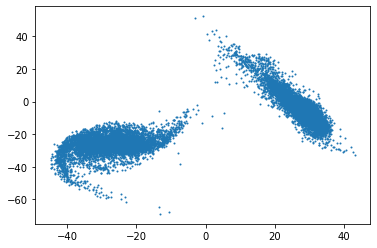

In [30]:
%matplotlib inline
plt.scatter(disk_pos[:, 0], disk_pos[:, 1], marker='o', s=1.0)

# Stars

In [9]:
hb = plt.hexbin(disk_pos[:,0],disk_pos[:,1], gridsize=50, bins='log', cmap='inferno')
cb = plt.colorbar(hb)
cb.set_label('log10(N)')

# Gas

(-68.96485137939453, 52.406795501708984)

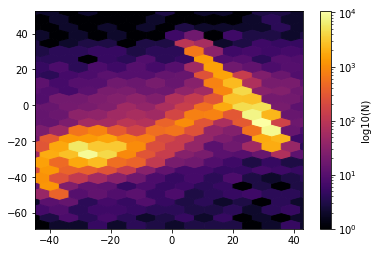

In [10]:
%matplotlib inline
hb = plt.hexbin(gas_pos[:,0],gas_pos[:,1], gridsize=500, bins='log', cmap='inferno')
cb = plt.colorbar(hb)
cb.set_label('log10(N)')
limx = np.percentile(disk_pos[:,0], [0,100])
limy = np.percentile(disk_pos[:,1], [0,100])
plt.xlim(limx)
plt.ylim(limy)

# Determining the center of the image

(-68.96485137939453, 52.406795501708984)

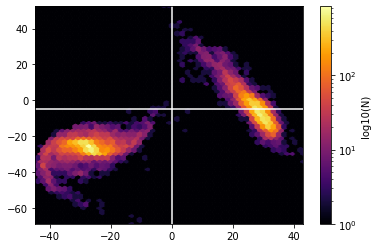

In [11]:
%matplotlib inline
xcent = -0
ycent = -5

plt.vlines(xcent,limy[0], limy[1], color='white')
plt.hlines(ycent,limx[0], limx[1], color='white')

hb = plt.hexbin(disk_pos[:,0],disk_pos[:,1], gridsize=50, bins='log', cmap='inferno')
cb = plt.colorbar(hb)
cb.set_label('log10(N)')
plt.xlim(limx)
plt.ylim(limy)

# Making Star and gas images

In [53]:
dimx = 100
dimy = 100

map_rad_vel = density_map(gas_pos, gas_vel[:,2] , xcent, ycent, ima_size=[dimx, dimy], scpix=1.5)
map_star=density_map(disk_pos, disk_mass, xcent, ycent, 'sum', ima_size=[dimx, dimy], scpix=1.5)
map_gas=density_map(gas_pos, gas_mass, xcent, ycent, 'sum', ima_size=[75, 75], scpix=2)

<ipython-input-4-73771edb7e06>:12: RuntimeWarning: Mean of empty slice
  gal_den[ind] = np.nanmean(gal_prop[cond])


# Radial Velocity map

<IPython.core.display.Javascript object>


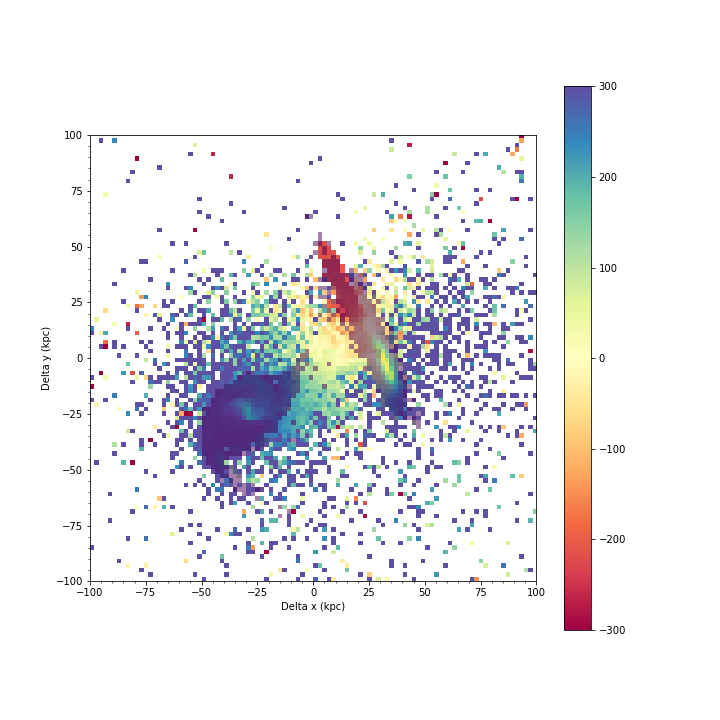

In [49]:
%matplotlib nbagg
plt.figure(figsize=(10,10))
cb=plt.imshow(-map_rad_vel, origin='lower', cmap='Spectral', vmin=-300, vmax=300, interpolation='none',
             extent=[-dimx,dimx,-dimy,dimy])

cb = plt.colorbar(cb)

plt.imshow(map_star, origin='lower', vmin=np.nanpercentile(map_star,10), alpha=0.5,
                                     vmax=np.nanpercentile(map_star,99.8), interpolation='none',
           extent=[-dimx,dimx,-dimy,dimy])



plt.minorticks_on()
plt.xlabel("Delta x (kpc)")
plt.ylabel("Delta y (kpc)")
plt.savefig('../Figures/orbits_21th_attempt/velocity'+ name)

# Star and gas Maps

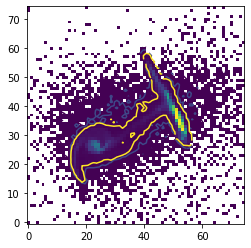

In [45]:
%matplotlib inline
plt.imshow(map_gas, origin='lower', vmin=np.nanpercentile(map_gas,10), alpha=1,
                                     vmax=np.nanpercentile(map_gas,99.8), interpolation='none')

plt.contour(map_gas, np.nanpercentile(map_gas,[50,70,80]), origin='lower',)

In [51]:
kernel = Gaussian2DKernel(x_stddev=0.2)
smooth = convolve(map_gas, kernel)
smooth[np.isnan(map_gas)]=np.nan

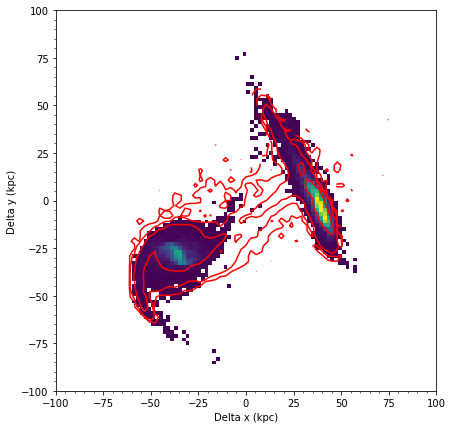

In [54]:
%matplotlib inline
plt.figure(figsize=(7,7))
#cb=plt.imshow(map_rad_vel, origin='lower', cmap='Spectral', vmin=-600, vmax=300, interpolation='none')

plt.imshow(map_star, origin='lower', vmin=np.nanpercentile(map_star,10), cmap='viridis',
                                     vmax=np.nanpercentile(map_star,99.8), interpolation='none',
           extent=[-dimx,dimx,-dimy,dimy])

plt.contour(smooth, np.nanpercentile(smooth,[70,80,90,99]), origin='lower', 
            extent=[-dimx,dimx,-dimy,dimy], colors='red')


plt.minorticks_on()
plt.xlabel("Delta x (kpc)")
plt.ylabel("Delta y (kpc)")
plt.savefig('../Figures/orbits_21th_attempt/density'+ name)